# SimPEG: FDEM

Some oddities with SimPEG. I mentioned them in Slack and we discussed it to some extent, but in Slack they will get lost over time...

In [1]:
import SimPEG
import discretize
import numpy as np
import matplotlib.pyplot as plt
from pymatsolver import Pardiso
from matplotlib.colors import LogNorm
import SimPEG.electromagnetics.frequency_domain as fdem

In [2]:
# Simple small mesh
hx = [(120, 5, -1.2), (120, 14), (120, 5, 1.2)]
mesh = discretize.TensorMesh([hx, hx, hx], x0="CCC")

# Frequency and conductivity model
frequency = 1
cond_model = np.ones(mesh.n_cells)

## 1. Repeatability

### Issue
Repeated runs of exactly the same **do not produce exactly the same** results.

In [3]:
# Source and Survey
src = fdem.sources.LineCurrent([], location=[[-100, 0, 0], [100, 0, 0]], frequency=frequency)
survey = fdem.Survey([src, ])

# Simulation
sim = fdem.simulation.Simulation3DElectricField(
    mesh, survey=survey, solver=Pardiso,
    sigmaMap=SimPEG.maps.IdentityMap(mesh),
)
 
# Run two runs
se1 = sim.fields(cond_model)[survey.source_list[0], 'e'][:, 0]
se2 = sim.fields(cond_model)[survey.source_list[0], 'e'][:, 0]

# Compare
diff = abs(se1 - se2)
print(f"Max diff between two SimPEG runs: {max(diff):.2e}")

Max diff between two SimPEG runs: 1.37e-19


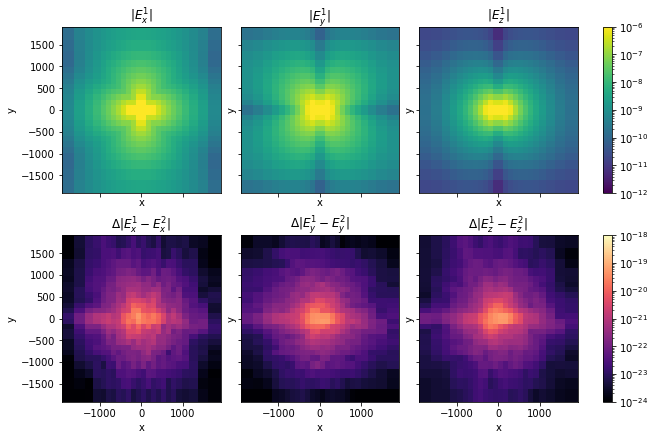

In [4]:
inp_f = {'view': 'abs', 'pcolor_opts': {'norm': LogNorm(vmin=1e-12, vmax=1e-6)}}
inp_d = {'view': 'abs', 'pcolor_opts': {'norm': LogNorm(vmin=1e-24, vmax=1e-18), 'cmap': 'magma'}}

fig, axs = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True, constrained_layout=True)

f1 = mesh.plot_slice(se1[:mesh.n_edges_x], v_type='Ex', ax=axs[0, 0], **inp_f)
mesh.plot_slice(se1[mesh.n_edges_x:-mesh.n_edges_z], v_type='Ey', ax=axs[0, 1], **inp_f)
mesh.plot_slice(se1[-mesh.n_edges_z:], v_type='Ez', ax=axs[0, 2], **inp_f)
axs[0, 0].set_title('$|E_x^1$|')
axs[0, 1].set_title('$|E_y^1$|')
axs[0, 2].set_title('$|E_z^1$|')
fig.colorbar(f1[0], ax=axs[0, :], fraction=0.07)

f1 = mesh.plot_slice(diff[:mesh.n_edges_x], v_type='Ex', ax=axs[1, 0], **inp_d)
mesh.plot_slice(diff[mesh.n_edges_x:-mesh.n_edges_z], v_type='Ey', ax=axs[1, 1], **inp_d)
mesh.plot_slice(diff[-mesh.n_edges_z:], v_type='Ez', ax=axs[1, 2], **inp_d)
axs[1, 0].set_title('$\Delta|E_x^1-E_x^2$|')
axs[1, 1].set_title('$\Delta|E_y^1-E_y^2$|')
axs[1, 2].set_title('$\Delta|E_z^1-E_z^2$|')

fig.colorbar(f1[0], ax=axs[1, :], fraction=0.07)

## 2. Vertical magnetic field

### Issue
The vertical electric field due to a vertical magnetic source should be **all zero**, but it isn't, and it has a strange pattern.

In [5]:
# Source and Survey
sources = [
    fdem.sources.MagDipole(frequency=frequency, location=np.r_[0, 0, 0], orientation="z"),
]
survey = fdem.Survey(sources)

# Simulation
simulation_simpeg = fdem.Simulation3DMagneticFluxDensity(
    mesh, survey=survey, solver=Pardiso,
    sigmaMap=SimPEG.maps.IdentityMap(mesh),
)

# Get Ez field
fields = simulation_simpeg.fields(cond_model)
sefield = fields[survey.source_list[0], 'e']
sez = sefield[-mesh.n_edges_z:].reshape(mesh.shape_edges_z, order='F')

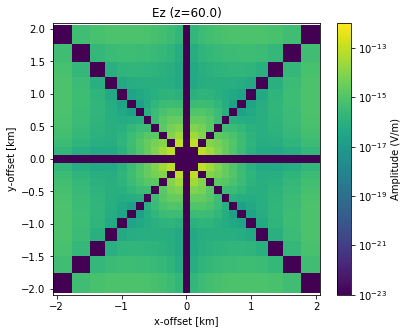

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

c = ax.pcolormesh(mesh.nodes_x/1e3, mesh.nodes_y/1e3, abs(sez[:, :, mesh.nCz//2].T),
                  norm=LogNorm(vmin=1e-23, vmax=1e-12))
fig.colorbar(c, label=r"Amplitude (V/m)")

ax.set_title(f'Ez (z={mesh.vectorCCz[mesh.nCz//2]})')
ax.set_ylabel('y-offset [km]')
ax.set_xlabel('x-offset [km]')
ax.axis('equal');

In [7]:
SimPEG.Report()

--------------------------------------------------------------------------------
  Date: Sun Feb 06 09:13:01 2022 CET

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 7.7 GiB
       Environment : Jupyter

  Python 3.8.10 | packaged by conda-forge | (default, May 11 2021, 07:01:05)
  [GCC 9.3.0]

            SimPEG : 0.16.0
        discretize : 0.7.2
       pymatsolver : 0.1.3
        vectormath : 0.2.2
        properties : 0.6.1
             numpy : 1.22.2
             scipy : 1.5.3
            cython : 0.29.24
           IPython : 7.26.0
        matplotlib : 3.5.1
        ipywidgets : 7.6.3

  Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904
  for Intel(R) 64 architecture applications
--------------------------------------------------------------------------------